# Business Case 2 (Hotel Cancellations)

In [1]:
# libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import time
from matplotlib import pyplot
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
import graphviz
import pydotplus

In [2]:
# Load data 
df = pd.read_csv('H2.csv', sep = ',')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79330 non-null  int64  
 1   LeadTime                     79330 non-null  int64  
 2   ArrivalDateYear              79330 non-null  int64  
 3   ArrivalDateMonth             79330 non-null  object 
 4   ArrivalDateWeekNumber        79330 non-null  int64  
 5   ArrivalDateDayOfMonth        79330 non-null  int64  
 6   StaysInWeekendNights         79330 non-null  int64  
 7   StaysInWeekNights            79330 non-null  int64  
 8   Adults                       79330 non-null  int64  
 9   Children                     79326 non-null  float64
 10  Babies                       79330 non-null  int64  
 11  Meal                         79330 non-null  object 
 12  Country                      79306 non-null  object 
 13  MarketSegment   

In [4]:
# Check duplicated observations
df.loc[df.duplicated(keep=False), :]
# the duplicated rows are a coincidence (i.e. they are different bookings even though they have the same values)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
8,1,62,2015,July,27,2,2,3,2,0.0,...,No Deposit,8,NULL,0,Transient,76.50,0,1,No-Show,2015-07-02
9,1,62,2015,July,27,2,2,3,2,0.0,...,No Deposit,8,NULL,0,Transient,76.50,0,1,No-Show,2015-07-02
10,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
12,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
17,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79292,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79293,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79294,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79312,0,175,2017,August,35,31,1,3,1,0.0,...,No Deposit,42,NULL,0,Transient,82.35,0,1,Check-Out,2017-09-04


In [5]:
# there's  missing data on the variable 'Children' that we prefer to drop instead of making an error replacing it by a possible value
df = df[~df['Children'].isna()] # only 4 observations

In [6]:
# 24 observations without country also to drop 
df =  df[~df['Country'].isna()] 

In [7]:
# dropping the 'Country' and 'DepositType' variables
# country information is only confirmed when the customer checks in, the hotel put default to "PRT"
# variable extracted in a wrong way and its quality was compromised
df.drop(['Country','DepositType'], axis = 1, inplace = True)

In [8]:
# Data leakage - information after the moment we want our model to identify possible cancellations
df.drop(['AssignedRoomType','DaysInWaitingList','ReservationStatus','ReservationStatusDate',], axis = 1, inplace = True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79302 entries, 0 to 79329
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79302 non-null  int64  
 1   LeadTime                     79302 non-null  int64  
 2   ArrivalDateYear              79302 non-null  int64  
 3   ArrivalDateMonth             79302 non-null  object 
 4   ArrivalDateWeekNumber        79302 non-null  int64  
 5   ArrivalDateDayOfMonth        79302 non-null  int64  
 6   StaysInWeekendNights         79302 non-null  int64  
 7   StaysInWeekNights            79302 non-null  int64  
 8   Adults                       79302 non-null  int64  
 9   Children                     79302 non-null  float64
 10  Babies                       79302 non-null  int64  
 11  Meal                         79302 non-null  object 
 12  MarketSegment                79302 non-null  object 
 13  DistributionChan

In [10]:
# Pandas profiling
ProfileReport(df, minimal=True)

In [11]:
# four types of new customers
# customers who were never hotel clients because they canceled their previous bookings
len(df[(df['IsRepeatedGuest'] == 0) & (df['PreviousCancellations'] != 0) & (df['PreviousBookingsNotCanceled'] == 0)])
# 4633 customers 

    
# customers who were never hotel clients because they didn't show in their previous bookings
len(df[(df['IsRepeatedGuest'] == 0) & (df['PreviousBookingsNotCanceled'] != 0) & (df['PreviousCancellations'] == 0)])
# 159 customers


#customers who were never hotel clients because they canceled or didn't show in their previous bookings
len(df[(df['IsRepeatedGuest'] == 0) & (df['PreviousBookingsNotCanceled'] != 0) & (df['PreviousCancellations'] != 0)])
# 14 customers


# customers who were never hotel clients because they didn't make any booking in the hotel
len(df[(df['IsRepeatedGuest'] == 0) & (df['PreviousBookingsNotCanceled'] == 0) & (df['PreviousCancellations'] == 0)])
# 72464 customers

# repeated customers
len(df[(df['IsRepeatedGuest'] == 1)])
# the hotel has 2032 repeated customers

2032

In [12]:
# treat high cardinality from Agent and Company
agent = df['Agent'].value_counts(sort=True)[:10].index.tolist()
df['Agent'] = np.where(~df['Agent'].isin(agent), 'Other', df['Agent'])

company = df['Company'].value_counts(sort=True)[:1].index.tolist()
df['Company'] = np.where(~df['Company'].isin(company), 'Other', df['Company'])

In [13]:
# dropping the rows with 'Babies' = 9 and 10 
df = df[~(df['Babies'] >= 9)]
# we kept 79324 observations, only dropping 2

In [14]:
df_out = df.copy()

In [15]:
metric_out = ['LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
              'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'Babies', 'PreviousCancellations',
              'PreviousBookingsNotCanceled', 'ADR','RequiredCarParkingSpaces', 'TotalOfSpecialRequests']

### Outlier analysis ?

In [16]:
df_LOF = df_out[metric_out].copy()

clf = LocalOutlierFactor(n_neighbors=20)
lof = clf.fit_predict(df_LOF)

len(lof[lof==-1])

6661

In [17]:
##### Extended Isolation Forest# matrix with values
X = df_out[metric_out].values
clf = IsolationForest(n_estimators=300, random_state=42, n_jobs=-1,behaviour='new',
                    max_samples = 'auto', contamination='auto', max_features=1.0, bootstrap=True)
clf.fit(X)
isolation_forest = clf.predict(X)


isolation_forest_outliers = [True if x == -1 else False for x in isolation_forest]
sum(isolation_forest_outliers*1)

7640

### New features 

In [16]:
# Sum variables that can "complete" each other
df['Persons'] = df['Adults']+ df['Children'] + df['Babies']
df['StaysInNights'] = df['StaysInWeekendNights'] + df['StaysInWeekNights']
df['PreviousBookings'] = df['PreviousCancellations'] + df['PreviousBookingsNotCanceled']

In [17]:
def get_percentage(series,ssum):
    per = round(series/ssum,2)
    return per.replace(np.nan,0.0)

In [18]:
df['PercentageAdults'] = get_percentage(df['Adults'],df['Persons'])
df['PercentageChildren'] = get_percentage(df['Children'],df['Persons'])
df['PercentageBabies'] = get_percentage(df['Babies'],df['Persons'])


df['PercentageWeekendNights'] = get_percentage(df['StaysInWeekendNights'],df['StaysInNights'])
df['PercentageWeekNights'] = get_percentage(df['StaysInWeekNights'],df['StaysInNights'])


df['PercentageCancellations'] = get_percentage(df['PreviousCancellations'],df['PreviousBookings'])
df['PercentageBookingsNotCanceled'] = get_percentage(df['PreviousBookingsNotCanceled'],df['PreviousBookings'])

In [19]:
# Pandas profiling
ProfileReport(df, minimal=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79300 entries, 0 to 79329
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   IsCanceled                     79300 non-null  int64  
 1   LeadTime                       79300 non-null  int64  
 2   ArrivalDateYear                79300 non-null  int64  
 3   ArrivalDateMonth               79300 non-null  object 
 4   ArrivalDateWeekNumber          79300 non-null  int64  
 5   ArrivalDateDayOfMonth          79300 non-null  int64  
 6   StaysInWeekendNights           79300 non-null  int64  
 7   StaysInWeekNights              79300 non-null  int64  
 8   Adults                         79300 non-null  int64  
 9   Children                       79300 non-null  float64
 10  Babies                         79300 non-null  int64  
 11  Meal                           79300 non-null  object 
 12  MarketSegment                  79300 non-null 

In [21]:
non_metric = ['MarketSegment','DistributionChannel',
              'CustomerType','Agent','Company','ReservedRoomType',
              'IsRepeatedGuest','Meal','ArrivalDateMonth']
binary = ['IsRepeatedGuest']
metric = df.columns.drop(non_metric + ['IsCanceled']).to_list()

In [22]:
df['Agent'].replace({'          1':'1','          3':'3','          6':'6','          7':'7','          8':'8',
                    '          9':'9','         14':'14','         28':'28','         37':'37','       NULL':'not_applicable'},
                    inplace = True)
df['Company'].replace({'       NULL':'not_applicable'},inplace=True)
df['ReservedRoomType'].replace({'A               ':'A','B               ':'B',
                                'C               ':'C','D               ':'D',
                                'E               ':'E','F               ':'F',
                                'G               ':'G','P               ':'P'}, inplace = True)
df['Meal'].replace({'SC       ':'SC','BB       ':'BB','HB       ':'HB','FB       ':'FB'},inplace=True)

In [23]:
### encoding
#let's try to use integers on Meal and RoomType since we know they are ordinal
#df['Meal'].unique()
df['Meal2'] = df['Meal'].replace({'SC':1,'BB':2,'HB':3,'FB':4})
#df['ReservedRoomType'].unique()
df['ReservedRoomType2'] = df['ReservedRoomType'].replace({'A':1,'B':2,
                                'C':3,'D':4,'E':5,'F':6,'G':7,'P':8})

In [24]:
non_metric_encoding = non_metric
non_metric_encoding.remove(binary[0])

In [25]:
# use OneHotEncoder to encode the categorical features as dummy variable encoding
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(df[non_metric_encoding])
ohc_feat_names = ohc.get_feature_names(non_metric_encoding)
ohc_df = pd.DataFrame(ohc_feat, index=df.index, columns=ohc_feat_names)  

df = pd.concat([df.drop(columns=non_metric_encoding), ohc_df], axis=1)

In [26]:
ohc_df.columns

Index(['MarketSegment_Complementary', 'MarketSegment_Corporate',
       'MarketSegment_Direct', 'MarketSegment_Groups',
       'MarketSegment_Offline TA/TO', 'MarketSegment_Online TA',
       'DistributionChannel_Direct', 'DistributionChannel_GDS',
       'DistributionChannel_TA/TO', 'CustomerType_Group',
       'CustomerType_Transient', 'CustomerType_Transient-Party', 'Agent_14',
       'Agent_28', 'Agent_3', 'Agent_37', 'Agent_6', 'Agent_7', 'Agent_8',
       'Agent_9', 'Agent_Other', 'Agent_not_applicable',
       'Company_not_applicable', 'ReservedRoomType_B', 'ReservedRoomType_C',
       'ReservedRoomType_D', 'ReservedRoomType_E', 'ReservedRoomType_F',
       'ReservedRoomType_G', 'ReservedRoomType_P', 'Meal_FB', 'Meal_HB',
       'Meal_SC', 'ArrivalDateMonth_August', 'ArrivalDateMonth_December',
       'ArrivalDateMonth_February', 'ArrivalDateMonth_January',
       'ArrivalDateMonth_July', 'ArrivalDateMonth_June',
       'ArrivalDateMonth_March', 'ArrivalDateMonth_May',
       'A

In [27]:
df.corr()['IsCanceled'].abs().sort_values(ascending=False)

IsCanceled                    1.000000
LeadTime                      0.309344
PercentageCancellations       0.301403
TotalOfSpecialRequests        0.293819
MarketSegment_Groups          0.254700
                                ...   
ArrivalDateYear               0.002652
ArrivalDateMonth_September    0.002063
ArrivalDateMonth_December     0.001703
ReservedRoomType_C            0.001616
ArrivalDateWeekNumber         0.001308
Name: IsCanceled, Length: 73, dtype: float64

In [28]:
# Select the most correlated option for the same variable
to_drop = (['Meal2'] + # Dummy Meals have a higher correlation
          list(df.filter(regex='^Previous',axis=1).columns.values)[:-1] + # Percentage has a higher correlation
          list(df.filter(regex='^ReservedRoomType_',axis=1).columns.values) + # ReservedRoomType2 has a higher correlation
          list(df.filter(regex='^Percentage',axis=1).columns.values)[:3] + # Adults has a higher correlation. Children and babies are very similar
          list(df.filter(regex='^StaysInWeek',axis=1).columns.values) # Percentage has a slightly higher correlation
          )

df.drop(to_drop, axis=1,inplace=True)

In [29]:
df.shape

(79300, 58)

In [30]:
dupli = df.loc[df.duplicated(keep=False), :]
notdupli = df.drop_duplicates(subset=None, keep=False) 

## Spliting

In [31]:
X = notdupli.drop(['IsCanceled'], axis=1)
y = notdupli['IsCanceled']

seed = 42
test_size = 0.2

X_train_notdupli, X_test_notdupli, y_train_notdupli, y_test_notdupli = train_test_split(X, y, test_size=test_size,
                                                                                        stratify=y, random_state=seed)

X_dupli = dupli.drop(['IsCanceled'], axis=1)
y_dupli = dupli['IsCanceled']

seed = 42
test_size = 0.2

X_train_dupli, X_test_dupli, y_train_dupli, y_test_dupli = train_test_split(X_dupli, y_dupli, test_size=test_size,
                                                                                        stratify=y_dupli, random_state=seed)

In [32]:
X_train = pd.concat([X_train_notdupli,X_train_dupli])
y_train = pd.concat([y_train_notdupli,y_train_dupli])
X_test = pd.concat([X_test_notdupli,X_test_dupli])
y_test = pd.concat([y_test_notdupli,y_test_dupli])

In [33]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('_____________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train, digits=3))
    print(confusion_matrix(y_train, pred_train))


    print('_____________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val, digits=3))
    print(confusion_matrix(y_val, pred_val))

# Modeling

### Random Forest

In [69]:
# Feature selection takes some time
nof_list=np.arange(10,35)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = RandomForestClassifier(max_depth=18, random_state=42, n_jobs=-1)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
   
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 17
Score with 17 features: 0.859647


In [70]:
rf = RandomForestClassifier(max_depth=18, random_state=42, n_jobs=-1)

In [65]:
#rfe = RFE(estimator = rf, n_features_to_select = 17)

In [66]:
#X_rfe = rfe.fit_transform(X = X_train, y = y_train) 

In [67]:
#selected_features = pd.Series(rfe.support_, index = X_train.columns)
#selected_features

LeadTime                          True
ArrivalDateYear                   True
ArrivalDateWeekNumber             True
ArrivalDateDayOfMonth             True
Adults                           False
Children                         False
Babies                           False
IsRepeatedGuest                  False
BookingChanges                    True
ADR                               True
RequiredCarParkingSpaces         False
TotalOfSpecialRequests            True
Persons                           True
StaysInNights                     True
PreviousBookings                  True
PercentageWeekendNights          False
PercentageWeekNights              True
PercentageCancellations           True
PercentageBookingsNotCanceled    False
ReservedRoomType2                False
MarketSegment_Complementary      False
MarketSegment_Corporate          False
MarketSegment_Direct             False
MarketSegment_Groups              True
MarketSegment_Offline TA/TO      False
MarketSegment_Online TA  

In [68]:
rffeat = list(selected_features[selected_features==True].index)
rffeat

['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'BookingChanges',
 'ADR',
 'TotalOfSpecialRequests',
 'Persons',
 'StaysInNights',
 'PreviousBookings',
 'PercentageWeekNights',
 'PercentageCancellations',
 'MarketSegment_Groups',
 'DistributionChannel_TA/TO',
 'CustomerType_Transient',
 'CustomerType_Transient-Party',
 'Agent_9']

In [71]:
rffeat = ['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'BookingChanges',
 'ADR',
 'TotalOfSpecialRequests',
 'Persons',
 'StaysInNights',
 'PreviousBookings',
 'PercentageWeekNights',
 'PercentageCancellations',
 'MarketSegment_Groups',
 'DistributionChannel_TA/TO',
 'CustomerType_Transient',
 'CustomerType_Transient-Party',
 'Agent_9']

In [72]:
X_trainrf = X_train[rffeat]
X_testrf = X_test[rffeat]

In [73]:
rf.fit(X_trainrf, y_train)

labels_train = rf.predict(X_trainrf)
labels_val = rf.predict(X_testrf)

metrics(y_train = y_train, pred_train = labels_train, y_val = y_test, pred_val = labels_val)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.904     0.952     0.928     36979
           1      0.928     0.859     0.892     26461

    accuracy                          0.913     63440
   macro avg      0.916     0.906     0.910     63440
weighted avg      0.914     0.913     0.913     63440

[[35205  1774]
 [ 3718 22743]]
_____________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.845     0.929     0.885      9245
           1      0.885  

In [74]:
# trying to change threshold
threshold = 0.55
predicted_proba1 = rf.predict_proba(X_trainrf)
predictedtrain = (predicted_proba1 [:,1] >= threshold).astype('int')

predicted_proba2 = rf.predict_proba(X_testrf)
predictedtest = (predicted_proba2 [:,1] >= threshold).astype('int')

metrics(y_train = y_train, pred_train = predictedtrain, y_val = y_test, pred_val = predictedtest)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.885     0.961     0.921     36979
           1      0.937     0.826     0.878     26461

    accuracy                          0.904     63440
   macro avg      0.911     0.893     0.900     63440
weighted avg      0.907     0.904     0.903     63440

[[35521  1458]
 [ 4604 21857]]
_____________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.833     0.940     0.884      9245
           1      0.898  

No Skill: ROC AUC=0.500
RandomForest: ROC AUC=0.929


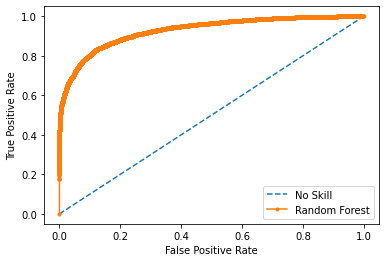

In [75]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
ns_probs_train = [0 for _ in range(len(y_train))]
# predict probabilities
lr_probs = rf.predict_proba(X_testrf)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RandomForest: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr_rf, ns_tpr_rf, _ = roc_curve(y_test, ns_probs)
lr_fpr_rf, lr_tpr_rf, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr_rf, ns_tpr_rf, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_rf, lr_tpr_rf, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

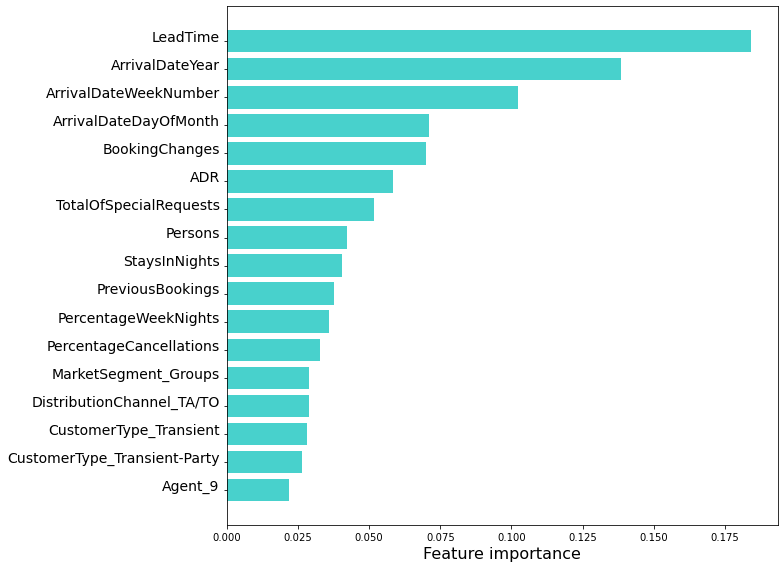

In [76]:
tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(rffeat))
fig, ax = plt.subplots(figsize=(11, 8))
ax.barh(y_ticks, tree_feature_importances[sorted_idx],  color = 'mediumturquoise')
rffeat.reverse()
ax.set_yticklabels(rffeat, fontdict = {'fontsize': 14,
 'fontweight': 10,
 'verticalalignment': 'baseline',
 'horizontalalignment': 'right'})
ax.set_yticks(y_ticks)
ax.set_xlabel('Feature importance',fontsize=16)
#ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

In [77]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 18,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### GradientBoost

In [130]:
"""
# Feature selection takes some time
nof_list=np.arange(10,35)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = GradientBoostingClassifier(max_depth=5, learning_rate=0.05, random_state=42)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
   
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
"""

'\n# Feature selection takes some time\nnof_list=np.arange(10,35)            \nhigh_score=0\n#Variable to store the optimum features\nnof=0           \nscore_list =[]\nfor n in range(len(nof_list)):\n    model = GradientBoostingClassifier(max_depth=5, learning_rate=0.05, random_state=42)\n    rfe = RFE(model,nof_list[n])\n    X_train_rfe = rfe.fit_transform(X_train,y_train)\n    X_test_rfe = rfe.transform(X_test)\n    model.fit(X_train_rfe,y_train)\n    \n    score = model.score(X_test_rfe,y_test)\n    score_list.append(score)\n   \n    if(score>high_score):\n        high_score = score\n        nof = nof_list[n]\nprint("Optimum number of features: %d" %nof)\nprint("Score with %d features: %f" % (nof, high_score))\n'

In [42]:
gb = GradientBoostingClassifier(max_depth=5, learning_rate=0.05, random_state=42)

In [163]:
#rfe = RFE(estimator = gb, n_features_to_select = 31)

In [93]:
#X_rfe = rfe.fit_transform(X = X_train, y = y_train) 

In [94]:
#selected_features = pd.Series(rfe.support_, index = X_train.columns)
#selected_features

In [131]:
#gbfeat = list(selected_features[selected_features==True].index)
#gbfeat

In [43]:
gbfeat = ['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'BookingChanges',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'Persons',
 'StaysInNights',
 'PercentageWeekNights',
 'PercentageCancellations',
 'MarketSegment_Direct',
 'MarketSegment_Groups',
 'MarketSegment_Offline TA/TO',
 'MarketSegment_Online TA',
 'DistributionChannel_Direct',
 'DistributionChannel_TA/TO',
 'CustomerType_Transient',
 'CustomerType_Transient-Party',
 'Agent_14',
 'Agent_28',
 'Agent_3',
 'Agent_6',
 'Agent_7',
 'Agent_8',
 'Agent_9',
 'Agent_Other',
 'Company_not_applicable',
 'Meal_HB',
 'ArrivalDateMonth_July']

In [44]:
X_traingb = X_train[gbfeat]
X_testgb = X_test[gbfeat]

In [45]:
gb.fit(X_traingb, y_train)

labels_train = gb.predict(X_traingb)
labels_val = gb.predict(X_testgb)

metrics(y_train = y_train, pred_train = labels_train, y_val = y_test, pred_val = labels_val)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.812     0.907     0.857     36979
           1      0.844     0.706     0.769     26461

    accuracy                          0.823     63440
   macro avg      0.828     0.807     0.813     63440
weighted avg      0.825     0.823     0.820     63440

[[33535  3444]
 [ 7771 18690]]
_____________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.806     0.907     0.854      9245
           1      0.843  

In [46]:
# trying to change threshold
threshold = 0.6
predicted_proba1 = gb.predict_proba(X_traingb)
predictedtrain = (predicted_proba1 [:,1] >= threshold).astype('int')

predicted_proba2 = gb.predict_proba(X_testgb)
predictedtest = (predicted_proba2 [:,1] >= threshold).astype('int')

metrics(y_train = y_train, pred_train = predictedtrain, y_val = y_test, pred_val = predictedtest)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.781     0.938     0.852     36979
           1      0.879     0.633     0.736     26461

    accuracy                          0.811     63440
   macro avg      0.830     0.786     0.794     63440
weighted avg      0.822     0.811     0.804     63440

[[34677  2302]
 [ 9702 16759]]
_____________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.774     0.937     0.848      9245
           1      0.876  

No Skill: ROC AUC=0.500
GradientBoosting: ROC AUC=0.891


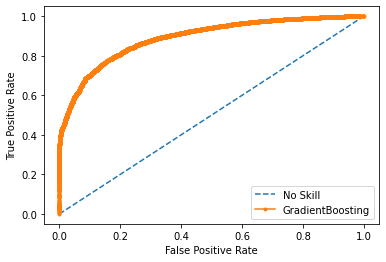

In [47]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
ns_probs_train = [0 for _ in range(len(y_train))]
# predict probabilities
lr_probs = gb.predict_proba(X_testgb)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('GradientBoosting: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr_gb, ns_tpr_gb, _ = roc_curve(y_test, ns_probs)
lr_fpr_gb, lr_tpr_gb, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr_gb, ns_tpr_gb, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_gb, lr_tpr_gb, marker='.', label='GradientBoosting')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

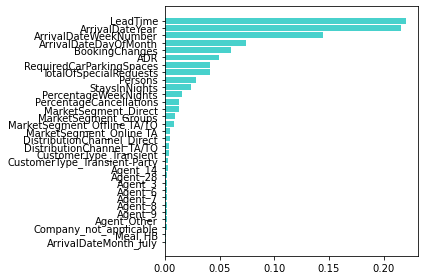

In [48]:
tree_feature_importances = gb.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(gbfeat))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx],  color = 'mediumturquoise')
gbfeat.reverse()
ax.set_yticklabels(gbfeat)
ax.set_yticks(y_ticks)
#ax.set_title("Gradient Boost Feature Importances")
fig.tight_layout()
plt.show()

In [49]:
gb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.05,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

### AdaBoost

In [51]:
"""
# Feature selection takes some time
nof_list=np.arange(10,35)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = AdaBoostClassifier(learning_rate=1.0,random_state=4)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
   
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
"""

'\n# Feature selection takes some time\nnof_list=np.arange(10,35)            \nhigh_score=0\n#Variable to store the optimum features\nnof=0           \nscore_list =[]\nfor n in range(len(nof_list)):\n    model = AdaBoostClassifier(learning_rate=1.0,random_state=4)\n    rfe = RFE(model,nof_list[n])\n    X_train_rfe = rfe.fit_transform(X_train,y_train)\n    X_test_rfe = rfe.transform(X_test)\n    model.fit(X_train_rfe,y_train)\n    \n    score = model.score(X_test_rfe,y_test)\n    score_list.append(score)\n   \n    if(score>high_score):\n        high_score = score\n        nof = nof_list[n]\nprint("Optimum number of features: %d" %nof)\nprint("Score with %d features: %f" % (nof, high_score))\n'

In [50]:
abdt = AdaBoostClassifier(learning_rate = 1.0, random_state=4)

In [149]:
#rfe = RFE(estimator = abdt, n_features_to_select = 25)

In [150]:
#X_rfe = rfe.fit_transform(X = X_train, y = y_train) 

In [151]:
#selected_features = pd.Series(rfe.support_, index = X_train.columns)
#selected_features

In [100]:
#abfeat = list(selected_features[selected_features==True].index)
#abfeat

In [52]:
abfeat = ['LeadTime',
 'ArrivalDateWeekNumber',
 'BookingChanges',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'StaysInNights',
 'PercentageWeekendNights',
 'PercentageCancellations',
 'PercentageBookingsNotCanceled',
 'ReservedRoomType2',
 'MarketSegment_Groups',
 'MarketSegment_Offline TA/TO',
 'MarketSegment_Online TA',
 'DistributionChannel_TA/TO',
 'CustomerType_Transient',
 'CustomerType_Transient-Party',
 'Agent_14',
 'Agent_28',
 'Agent_3',
 'Agent_7',
 'Agent_9',
 'Agent_not_applicable',
 'Meal_FB',
 'ArrivalDateMonth_July']

In [53]:
X_trainab = X_train[abfeat]
X_testab = X_test[abfeat]

In [54]:
abdt.fit(X_trainab, y_train)

labels_train = abdt.predict(X_trainab)
labels_val = abdt.predict(X_testab)

metrics(y_train = y_train, pred_train = labels_train, y_val = y_test, pred_val = labels_val)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.800     0.879     0.838     36979
           1      0.804     0.694     0.745     26461

    accuracy                          0.802     63440
   macro avg      0.802     0.786     0.791     63440
weighted avg      0.802     0.802     0.799     63440

[[32514  4465]
 [ 8109 18352]]
_____________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.795     0.884     0.837      9245
           1      0.807  

In [55]:
# trying to change threshold
threshold = 0.5
predicted_proba1 = abdt.predict_proba(X_trainab)
predictedtrain = (predicted_proba1 [:,1] >= threshold).astype('int')

predicted_proba2 = abdt.predict_proba(X_testab)
predictedtest = (predicted_proba2 [:,1] >= threshold).astype('int')

metrics(y_train = y_train, pred_train = predictedtrain, y_val = y_test, pred_val = predictedtest)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.800     0.879     0.838     36979
           1      0.804     0.694     0.745     26461

    accuracy                          0.802     63440
   macro avg      0.802     0.786     0.791     63440
weighted avg      0.802     0.802     0.799     63440

[[32514  4465]
 [ 8109 18352]]
_____________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.795     0.884     0.837      9245
           1      0.807  

No Skill: ROC AUC=0.500
AdaBoost: ROC AUC=0.861


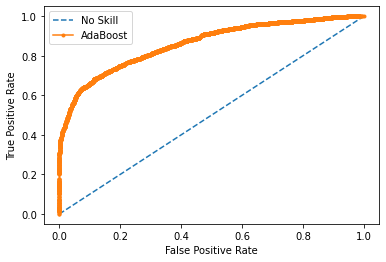

In [56]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
ns_probs_train = [0 for _ in range(len(y_train))]
# predict probabilities
lr_probs = abdt.predict_proba(X_testab)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('AdaBoost: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr_ab, ns_tpr_ab, _ = roc_curve(y_test, ns_probs)
lr_fpr_ab, lr_tpr_ab, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr_ab, ns_tpr_ab, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_ab, lr_tpr_ab, marker='.', label='AdaBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

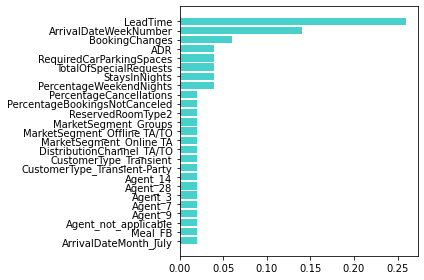

In [57]:
tree_feature_importances = abdt.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(abfeat))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx], color = 'mediumturquoise')
abfeat.reverse()
ax.set_yticklabels(abfeat)
ax.set_yticks(y_ticks)
#ax.set_title("Ada Boost Feature Importances")
fig.tight_layout()
plt.show()

In [58]:
abdt.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 4}

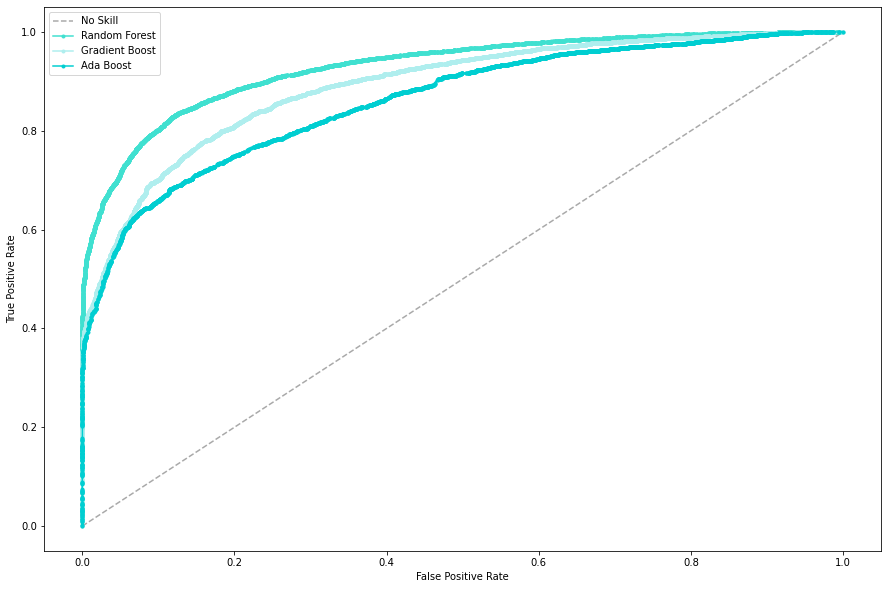

In [59]:
plt.figure(figsize=(15, 10))
pyplot.plot(ns_fpr_rf, ns_tpr_rf, linestyle='--', label='No Skill',color = 'darkgrey')
pyplot.plot(lr_fpr_rf, lr_tpr_rf, marker='.', label='Random Forest', color = 'turquoise')
pyplot.plot(lr_fpr_gb, lr_tpr_gb, marker='.', label='Gradient Boost', color = 'paleturquoise')
pyplot.plot(lr_fpr_ab, lr_tpr_ab, marker='.', label='Ada Boost', color = 'darkturquoise')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
plt.legend()
plt.show()